# Hacer Train - Test - Validation

In [3]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import random

In [7]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import random


# ----------------------------------------------------
# 1. Dividir raster en tiles y contar píxeles válidos
# ----------------------------------------------------
def crear_tiles_con_validos(ruta_raster, n_rows=5, n_cols=5):
    with rasterio.open(ruta_raster) as src:
        mask = src.dataset_mask() > 0  # True en píxeles válidos
        height, width = mask.shape
        transform = src.transform
        crs = src.crs

    row_edges = np.linspace(0, height, n_rows + 1, dtype=int)
    col_edges = np.linspace(0, width, n_cols + 1, dtype=int)

    tiles = []
    tile_id = 1

    for i in range(n_rows):
        for j in range(n_cols):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]

            valid_px = int(mask[r0:r1, c0:c1].sum())

            corners_px = [(c0, r0), (c1, r0), (c1, r1), (c0, r1)]
            corners_real = [transform * (c, r) for (c, r) in corners_px]
            poly = Polygon(corners_real)

            tiles.append({
                "tile_id": tile_id,
                "row": i,
                "col": j,
                "valid_px": valid_px,
                "split": "train",
                "geometry": poly,
            })
            tile_id += 1

    return tiles, crs



# ----------------------------------------------------
# 2. Agrupar tiles según densidad (alto/medio/bajo)
# ----------------------------------------------------
def estratificar_por_densidad(tiles):
    # Extraer valores
    vals = [t["valid_px"] for t in tiles]
    q33, q66 = np.quantile(vals, [0.33, 0.66])

    for t in tiles:
        if t["valid_px"] >= q66:
            t["densidad"] = "alta"
        elif t["valid_px"] >= q33:
            t["densidad"] = "media"
        else:
            t["densidad"] = "baja"

    return tiles



# ----------------------------------------------------
# 3. Vecindad: tiles vecinos NO pueden ir al mismo split
# ----------------------------------------------------
def vecinos(tile, tiles):
    """Devuelve lista de IDs de tiles adyacentes (8-direcciones)."""
    neigh = []
    for t in tiles:
        if t["tile_id"] == tile["tile_id"]:
            continue
        
        # Si están pegados en filas o columnas o diagonales
        if abs(t["row"] - tile["row"]) <= 1 and abs(t["col"] - tile["col"]) <= 1:
            neigh.append(t["tile_id"])
    return neigh



# ----------------------------------------------------
# 4. Algoritmo final de asignación
# ----------------------------------------------------
def asignar_splits(tiles, frac_val=0.20, frac_test=0.10):
    total_valid = sum(t["valid_px"] for t in tiles)
    objetivo_val = frac_val * total_valid
    objetivo_test = frac_test * total_valid

    # Agrupar por densidad
    densidades = {"alta": [], "media": [], "baja": []}
    for t in tiles:
        densidades[t["densidad"]].append(t)

    # Aleatorizar dentro de cada grupo
    for grupo in densidades.values():
        random.shuffle(grupo)

    # Crear lista global mezclada "nivelada"
    mezcla = []
    for a, m, b in zip(
        densidades["alta"] + [None]*10,
        densidades["media"] + [None]*10,
        densidades["baja"] + [None]*10,
    ):
        if a: mezcla.append(a)
        if m: mezcla.append(m)
        if b: mezcla.append(b)

    # Filtrar None
    mezcla = [x for x in mezcla if x]

    # Auxiliar para saber vecinos
    id_to_tile = {t["tile_id"]: t for t in tiles}

    def tiene_vecino_en_split(tile, split):
        for vid in vecinos(tile, tiles):
            if id_to_tile[vid]["split"] == split:
                return True
        return False

    # ---- Asignación de VALIDACIÓN ----
    acc_val = 0
    for t in mezcla:
        if acc_val >= objetivo_val:
            break
        if not tiene_vecino_en_split(t, "val"):
            t["split"] = "val"
            acc_val += t["valid_px"]

    # ---- Asignación de TEST ----
    acc_test = 0
    for t in mezcla:
        if acc_test >= objetivo_test:
            break
        if t["split"] == "train" and not tiene_vecino_en_split(t, "test"):
            t["split"] = "test"
            acc_test += t["valid_px"]

    return tiles, acc_val, acc_test, total_valid



# ----------------------------------------------------
# 5. Función principal
# ----------------------------------------------------
def generar_tiles_spatial_split(
    ruta_raster,
    n_rows=5,
    n_cols=5,
    frac_val=0.20,
    frac_test=0.10
):

    tiles, crs = crear_tiles_con_validos(ruta_raster, n_rows, n_cols)
    tiles = estratificar_por_densidad(tiles)
    tiles, acc_val, acc_test, total_valid = asignar_splits(tiles, frac_val, frac_test)

    # Convertir a GeoDataFrame
    gdf = gpd.GeoDataFrame(tiles, crs=crs)

    print("Píxeles válidos totales:", total_valid)
    print("Val   asignado:", acc_val, f"({acc_val/total_valid*100:.1f}%)")
    print("Test asignado:", acc_test, f"({acc_test/total_valid*100:.1f}%)")
    print("Train:", total_valid - acc_val - acc_test)

    return gdf

In [11]:
# ----------------------------------------------------
# EJECUCIÓN
# ----------------------------------------------------
ruta = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\perusat_recortado.tif"

gdf_tiles = generar_tiles_spatial_split(
    ruta_raster=ruta,
    n_rows=4,
    n_cols=4,
    frac_val=0.20,
    frac_test=0.10
)

Píxeles válidos totales: 722273412
Val   asignado: 180561330 (25.0%)
Test asignado: 90280665 (12.5%)
Train: 451431417


In [12]:
gdf_tiles.to_file("tiles_spatial_split_4x4.shp")
gdf_tiles

,tile_id,row,col,valid_px,split,geometry,densidad
0,1,0,0,45136821,train,"POLYGON ((619239.19 9276038.94, 624155.29 9276...",baja
1,2,0,1,45136821,val,"POLYGON ((624155.29 9276038.94, 629071.39 9276...",baja
2,3,0,2,45136821,test,"POLYGON ((629071.39 9276038.94, 633987.49 9276...",baja
3,4,0,3,45136821,val,"POLYGON ((633987.49 9276038.94, 638903.59 9276...",baja
4,5,1,0,45143844,train,"POLYGON ((619239.19 9271540.04, 624155.29 9271...",alta
5,6,1,1,45143844,train,"POLYGON ((624155.29 9271540.04, 629071.39 9271...",alta
6,7,1,2,45143844,train,"POLYGON ((629071.39 9271540.04, 633987.49 9271...",alta
7,8,1,3,45143844,train,"POLYGON ((633987.49 9271540.04, 638903.59 9271...",alta
8,9,2,0,45143844,train,"POLYGON ((619239.19 9267040.44, 624155.29 9267...",alta
9,10,2,1,45143844,test,"POLYGON ((624155.29 9267040.44, 629071.39 9267...",alta


# Unificar capas

In [ ]:
centros_poblados=gpd.read_file(r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\geometrias_finales_rural_urbano_fondo.gpkg")

In [18]:
centros_poblados.loc[centros_poblados['NOMCCPP_17']=='NO IDENTIFICADO - URBANO', 'AREA_17']=1

In [26]:
def clasificar(columna):
    if columna.__contains__('INEXACTO'):
        return 'DELIMITABLE INEXACTO'
    elif columna.__contains__(' EXACTO'):
        return 'DELIMITABLE EXACTO'
    elif columna.__contains__('IMPOSIBLE'):
        return 'IMPOSIBLE'
    else:
        return 'NO DELIMITABLE'

In [37]:
centros_poblados.loc[123:,'POSIBILIDAD']='DELIMITABLE INEXACTO'

In [39]:
centros_poblados.POSIBILIDAD=centros_poblados.POSIBILIDAD.apply(clasificar)

In [41]:
centros_poblados.POSIBILIDAD.value_counts()

POSIBILIDAD
DELIMITABLE INEXACTO    72
IMPOSIBLE               30
DELIMITABLE EXACTO      23
Name: count, dtype: int64

In [42]:
geometrias_centros_poblados_validas=centros_poblados[centros_poblados.POSIBILIDAD.isin(['DELIMITABLE INEXACTO', 'DELIMITABLE EXACTO'])]

In [47]:
geometrias_centros_poblados_validas=geometrias_centros_poblados_validas[~geometrias_centros_poblados_validas.geometry.isna()]

In [54]:
geometrias_centros_poblados_validas.to_file('geometrias_manuales_finales_validas_rural_urbano.gpkg')

# Creación de Dataset

In [62]:
# =============================================
#     GENERADOR DE DATASET FINAL (MULTICLASE)
# =============================================

import os
import numpy as np
import rasterio
from rasterio import features
from rasterio.windows import Window
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box

# =============================================================
# 🔧 1. CONFIGURACIÓN
# =============================================================

# TIFF GRANDE
ruta_tiff = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\perusat_recortado.tif"

# GEOMETRÍAS MANUALES (1 urbano, 2 rural)
ruta_geoms = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\geometrias_manuales_finales_validas_rural_urbano.gpkg"

# TILES ESPACIALES (train/valid/test)
ruta_tiles = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\tiles_spatial_split_4x4.shp"

# Carpeta de salida
carpeta_salida = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\dataset_final"
os.makedirs(carpeta_salida, exist_ok=True)

# Crear subcarpetas
splits = ["train", "val", "test"]
for sp in splits:
    os.makedirs(os.path.join(carpeta_salida, sp, "images"), exist_ok=True)
    os.makedirs(os.path.join(carpeta_salida, sp, "masks"), exist_ok=True)

# Patch params
PATCH_SIZE = 512
STRIDE = 256
NOINFO_VALUE = 255   # clase 255 = no información

# =============================================================
# 🔧 2. CARGAR INSUMOS
# =============================================================

print("Cargando raster...")
src = rasterio.open(ruta_tiff)

print("Cargando geometrías...")
gdf_geoms = gpd.read_file(ruta_geoms)
gdf_geoms = gdf_geoms.to_crs(src.crs)

print("Cargando tiles...")
tiles = gpd.read_file(ruta_tiles)
tiles = tiles.to_crs(src.crs)

# Campo que indica split: debe ser "train", "valid", "test"
campo_split = "split"    # ajusta si tiene otro nombre


# =============================================================
# 🔧 3. PROCESAR TILE POR TILE
# =============================================================

patch_id = 0

for idx, tile in tiles.iterrows():

    split = tile[campo_split]   # "train" / "valid" / "test"
    if split not in splits:
        print(f"Tile {idx} tiene split desconocido, saltando…")
        continue

    print(f"\n🟦 Procesando tile {idx} → {split}")

    # ==== 3.1 Recorte del TIFF al tile ====
    try:
        img_tile, transform_tile = mask(src, [tile.geometry], crop=True, nodata=NOINFO_VALUE)
    except:
        print("Tile vacío, saltando…")
        continue

    # img_tile tiene shape (C, H, W)
    tile_h, tile_w = img_tile.shape[1], img_tile.shape[2]

    # ==== 3.2 Filtrar geometrías que intersectan tile ====
    geoms_tile = gdf_geoms[gdf_geoms.intersects(tile.geometry)]

    # =============================================================
    # 🔧 4. GENERAR PATCHES
    # =============================================================

    for y in range(0, tile_h - PATCH_SIZE + 1, STRIDE):
        for x in range(0, tile_w - PATCH_SIZE + 1, STRIDE):

            window = Window(x, y, PATCH_SIZE, PATCH_SIZE)
            win_transform = rasterio.windows.transform(window, transform_tile)

            # ---- Extraer parche imagen ----
            img_patch = img_tile[:, y:y+PATCH_SIZE, x:x+PATCH_SIZE]

            # ---- Detectar nodata (255) ----
            nodata_mask = (img_patch[0] == NOINFO_VALUE)
            if nodata_mask.all():
                # 100% no info → no guardar
                continue

            # ---- Rasterizar geometrías manuales dentro del patch ----
            bbox = box(*rasterio.windows.bounds(window, transform_tile))
            inter = geoms_tile[geoms_tile.intersects(bbox)]

            # Clase base = background (0)
            mask_patch = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype="uint8")

            # Asignar nodata (255)
            mask_patch[nodata_mask] = NOINFO_VALUE

            if not inter.empty:
                shapes = ((geom, cls) for geom, cls in zip(inter.geometry, inter["AREA_17"]))

                raster = features.rasterize(
                    shapes=shapes,
                    out_shape=(PATCH_SIZE, PATCH_SIZE),
                    fill=0,
                    transform=win_transform,
                    dtype="uint8"
                )

                # Donde img_patch es válida, sobreescribir background
                mask_patch[mask_patch != NOINFO_VALUE] = raster[mask_patch != NOINFO_VALUE]

            # ---- Evitar guardar patches 100% vacío (solo fondo y/o nodata) ----
            unique_classes = np.unique(mask_patch)
            if set(unique_classes).issubset({0, NOINFO_VALUE}):
                continue

            # ---- Guardar TIFF georreferenciado ----
            out_img = os.path.join(carpeta_salida, split, "images", f"img_{patch_id:06d}.tif")
            out_mask = os.path.join(carpeta_salida, split, "masks", f"mask_{patch_id:06d}.tif")

            # Guardar imagen
            with rasterio.open(
                out_img, "w",
                driver="GTiff",
                height=PATCH_SIZE,
                width=PATCH_SIZE,
                count=img_patch.shape[0],
                dtype=img_patch.dtype,
                crs=src.crs,
                transform=win_transform
            ) as dst:
                dst.write(img_patch)

            # Guardar máscara
            with rasterio.open(
                out_mask, "w",
                driver="GTiff",
                height=PATCH_SIZE,
                width=PATCH_SIZE,
                count=1,
                dtype="uint8",
                crs=src.crs,
                transform=win_transform,
                nodata=NOINFO_VALUE
            ) as dst:
                dst.write(mask_patch, 1)

            patch_id += 1

print("\n🎉 LISTO: Dataset generado correctamente.")
print(f"Total de parches generados: {patch_id}")

Cargando raster...
Cargando geometrías...
Cargando tiles...

🟦 Procesando tile 0 → train

🟦 Procesando tile 1 → val

🟦 Procesando tile 2 → test

🟦 Procesando tile 3 → val

🟦 Procesando tile 4 → train

🟦 Procesando tile 5 → train

🟦 Procesando tile 6 → train

🟦 Procesando tile 7 → train

🟦 Procesando tile 8 → train

🟦 Procesando tile 9 → test

🟦 Procesando tile 10 → train

🟦 Procesando tile 11 → val

🟦 Procesando tile 12 → val

🟦 Procesando tile 13 → train

🟦 Procesando tile 14 → train

🟦 Procesando tile 15 → train

🎉 LISTO: Dataset generado correctamente.
Total de parches generados: 3749


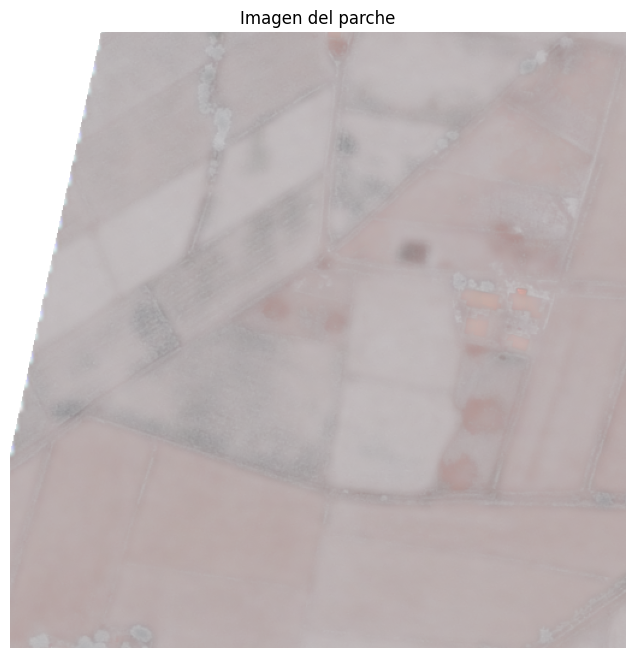

In [66]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Ruta a un parche cualquiera
ruta_img = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\dataset_final\train\images\img_000123.tif"

with rasterio.open(ruta_img) as src:
    img = src.read()              # (C, H, W)
    img = np.transpose(img, (1, 2, 0))  # → (H, W, C)

# Normalizar si es necesario (por si la imagen es muy oscura)
img_norm = (img - img.min()) / (img.max() - img.min() + 1e-6)

plt.figure(figsize=(8, 8))
plt.imshow(img_norm)
plt.title("Imagen del parche")
plt.axis("off")
plt.show()

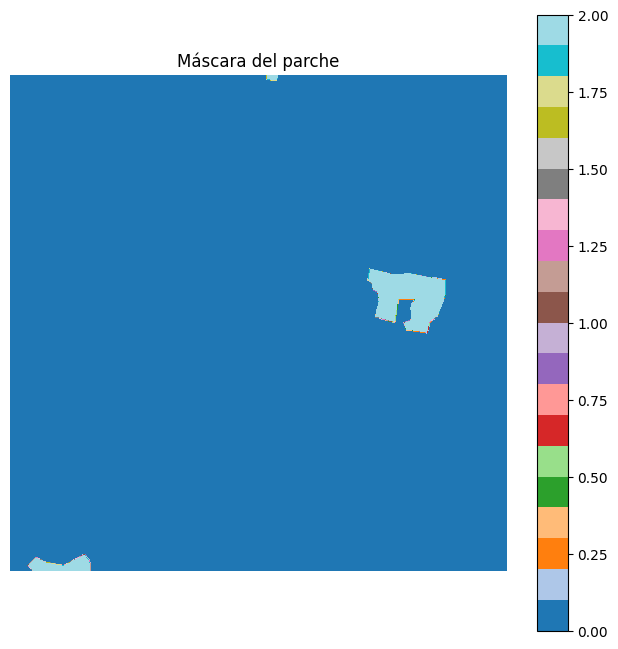

In [1]:
import rasterio
import matplotlib.pyplot as plt

ruta_mask = r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\dataset_final\train\masks\mask_000123.tif"

with rasterio.open(ruta_mask) as src:
    mask = src.read(1)   # banda única

plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap="tab20")   # buena paleta para clases
plt.title("Máscara del parche")
plt.colorbar()
plt.axis("off")
plt.show()
